# Image Segmentation
## UNet

In [1]:
#  Importing Required Libraries

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from scipy import misc
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


In [2]:
# Reading the Images (Feature Images)

i = 0
X = np.empty((2103,256,256))

for root,dirs,files in os.walk("/home/qli/Rami/train/image/"): # Choose your location of feature images
    for filename in files:
        img = misc.imread(root+filename)
        img = misc.imresize(img, (256,256), interp='bilinear', mode=None)
        X[i] = img/img.max()
        i+=1

/home/qli/.local/lib64/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/qli/.local/lib64/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


In [3]:
# Readung the Label Images
i = 0
Y = np.empty((2103,256,256))

for root,dirs,files in os.walk("/home/qli/Rami/train/label/"): # Choose your location of label images
    for filename in files:
        img = misc.imread(root+filename)
        img = misc.imresize(img, (256,256), interp='bilinear', mode=None)

        Y[i] = img/img.max()
        i+=1


/home/qli/.local/lib64/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/home/qli/.local/lib64/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [4]:
# Checking Images Shapes

print(np.shape(X))
print(np.shape(Y))

(2103, 256, 256)
(2103, 256, 256)


<function matplotlib.pyplot.show(*args, **kw)>

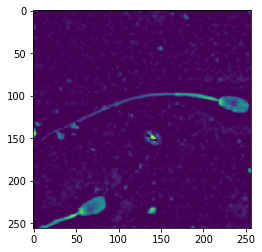

In [5]:
# Visualizing Some Images

plt.imshow(X[10])
plt.show

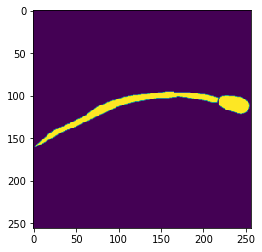

In [6]:
# Visualizing Some Images

plt.imshow(Y[10])
plt.show()

In [7]:
# Reshaping the Images to be Inputted into the Model

X = np.reshape(X, (2103,256,256,1))
Y = np.reshape(Y, (2103,256,256,1))

In [8]:
# Creating the Model Architecture

import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [9]:
# Model Execution

model = unet()

model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)

model.fit(x = X, y = Y,epochs=10, batch_size=5, callbacks = [model_checkpoint])

/home/qli/.local/lib64/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/10
2103/2103 [==============================] - 127s 60ms/step - loss: 0.1218 - acc: 0.9623

Epoch 00001: loss improved from inf to 0.12181, saving model to unet_membrane.hdf5
Epoch 2/10
2103/2103 [==============================] - 119s 57ms/step - loss: 0.0391 - acc: 0.9648

Epoch 00002: loss improved from 0.12181 to 0.03908, saving model to unet_membrane.hdf5
Epoch 3/10
2103/2103 [==============================] - 119s 57ms/step - loss: 0.0375 - acc: 0.9696

Epoch 00003: loss improved from 0.03908 to 0.03752, saving model to unet_membrane.hdf5
Epoch 4/10
2103/2103 [==============================] - 119s 57ms/step - loss: 0.0363 - acc: 0.9766

Epoch 00004: loss improved from 0.03752 to 0.03628, saving model to unet_membrane.hdf5
Epoch 5/10
2103/2103 [==============================] - 119s 57ms/step - loss: 0.0354 - acc: 0.9771

Epoch 00005: loss improved from 0.03628 to 0.03535, saving model to unet_membrane.hdf5
Epoch 6/10
2103/2103 [==============================] - 119s 57m

In [10]:
# Reading Test Images

import os
i = 0
X_test = np.empty((30,256,256))

for root,dirs,files in os.walk("/home/qli/Rami/test/"): # Choose your location of test images
    for i in range(0,29):
        img = misc.imread("/home/qli/Rami/test/"+str(i)+".png")
        img = misc.imresize(img, (256,256), interp='bilinear', mode=None)
        X_test[i] = img/img.max()


/home/qli/.local/lib64/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/home/qli/.local/lib64/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


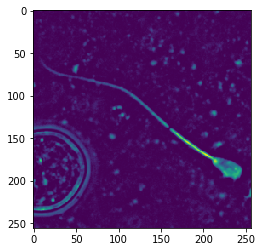

In [11]:
# Visualizing 1 Test Image

plt.imshow(X_test[3])
plt.show()

In [12]:
# Reshaping the Test Images to Input into the Model

X_test = np.reshape(X_test, (30,256,256,1))

In [13]:
# Running the Model on Test Images

results = model.predict(X_test,30,verbose=1)
#saveResult("C:/Users/Reese/Desktop/Dr Nahil/Image Segmentation/all~/predictions",results)

30/30 [==============================] - 3s 101ms/step


In [14]:
# Reshaping the Resulting Images to be able to be Visualized

results = np.reshape(results, (30,256,256))

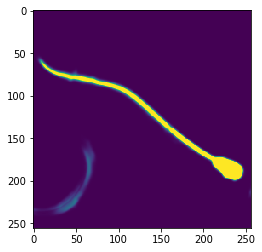

In [15]:
# Visualizing the Corresponding Resulting Image 

plt.imshow(results[3])
plt.show()

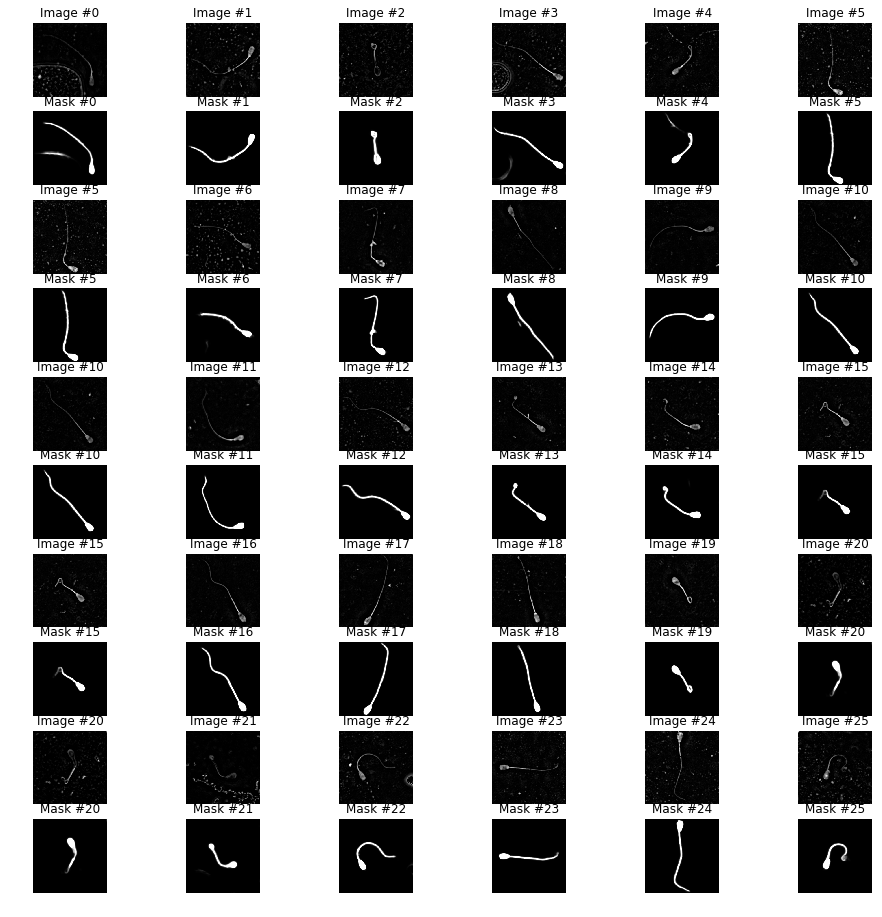

In [16]:
# Illustration of All Test and Resulting Images

plt.figure(figsize=(16,16))
x, y = 6,5
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = 5*i+j 
        plt.imshow(np.squeeze(X_test[pos]),cmap='gray')
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(results[pos]),cmap='gray')
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
#plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()
